In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from random import randint

In [0]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [0]:
num_classes = 10

# preprocessing
train_images = train_images / 255.0
test_images = test_images / 255.0

# change labels to categorical
train_labels_bin = keras.utils.to_categorical(train_labels, num_classes)
test_labels_bin = keras.utils.to_categorical(test_labels, num_classes)

In [0]:
def mnistModel():
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation='softmax')
  ])
    
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])
  return model

### Standard Training

In [0]:
model = mnistModel()

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_results = model.fit(train_images, train_labels_bin, batch_size=32, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2618 - accuracy: 0.9248
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1180 - accuracy: 0.9650
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0807 - accuracy: 0.9752
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0600 - accuracy: 0.9820
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0466 - accuracy: 0.9856
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0362 - accuracy: 0.9889
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0292 - accuracy: 0.9912
Epoch 8/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0236 - accuracy: 0.9924
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0190 - accuracy: 0.9942
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.016

In [0]:
results = model.evaluate(test_images, test_labels_bin, batch_size=128)

79/79 [==============================] - 0s 2ms/step - loss: 0.1159 - accuracy: 0.9758


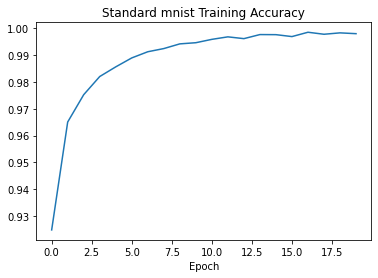

In [0]:
sns.lineplot(list(range(len(train_results.history['accuracy']))), train_results.history['accuracy'])
plt.title('Standard mnist Training Accuracy')
plt.xlabel('Epoch')
plt.show()

### Setup for Federated Learning

In [0]:
class FederatedClient:
  trainImages = None
  trainLabels = None
  model = None

  def __init__(self, model, trainImages, trainLabels):
    self.model = model
    self.trainImages = trainImages
    self.trainLabels = trainLabels

  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      self.model.weights[layer_index].assign(serverModel.weights[layer_index])
  
  def fit(self):
    self.model.fit(self.trainImages, self.trainLabels, batch_size=32, epochs=1)

  def evaluate(self, testImages, testLabels, globalAccuracy, batch_size=32):
    # evaluate accuracy and utility
    acc = self.evaluate_accuracy(testImages, testLabels, batch_size)
    utility = self.evaluate_utility(acc[1], globalAccuracy)
    return acc, utility

  def evaluate_accuracy(self, testImages, testLabels, batch_size=32):
    return self.model.evaluate(testImages, testLabels, batch_size)

  def evaluate_utility(self, localAccuracy, globalAccuracy):
    # utility = local acc - global acc
    return localAccuracy - globalAccuracy

In [0]:
# Server class holds a server model and testing data
class FederatedServer:

  model = None
  testImages = None
  testLabels = None

  def __init__(self, model, testImages, testLabels):
    self.model = model
    self.testImages = testImages
    self.testLabels = testLabels

  # Averaging client models using the averaging method
  def average(self, federatedClients, averagingMethod):
    allWeights = []

    for i in range(len(federatedClients)):
      allWeights.append(federatedClients[i].model.weights)
    
    avgWeights = averagingMethod(allWeights) 
    
    for layer_index in range(len(avgWeights)):
      self.model.weights[layer_index].assign(avgWeights[layer_index])
  
  # evaluate the test accuracies and utility for all clients
  def evaluate_clients(self, federatedClients, globalAccuracy):
    results = []
    for client in federatedClients:
      results.append(client.evaluate(self.testImages, self.testLabels, globalAccuracy, batch_size=32))
    return results

  # Testing the server model
  def evaluate(self):
    return self.model.evaluate(self.testImages, self.testLabels, batch_size=32)

In [0]:
# Adversarial Client 1: returns a constant (all ones) for every weight in the model
class AdversarialClient(FederatedClient):
  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.model.weights[layer_index].shape
      self.model.weights[layer_index].assign(np.ones(layer_shape))


  def fit(self):
    pass

In [0]:
# Adversarial Client 2: returns a Uniform(0, 1) value for each weight in model
class AdversarialClient2(FederatedClient):

  def __init__(self, model, trainImages, trainLabels):
    super(AdversarialClient2, self).__init__(model, trainImages, trainLabels)

  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.model.weights[layer_index].shape
      self.model.weights[layer_index].assign(np.random.uniform(size = layer_shape))

  def fit(self):
    pass

In [0]:
# Adversarial Client 3: returns noisy trained model, then substracts noise from aggregate model to get more useful model
class AdversarialClient3(FederatedClient):
  def __init__(self, model, trainImages, trainLabels):
    super(AdversarialClient3, self).__init__(model, trainImages, trainLabels)
    self.noise = None
    self.lastNoise = None
    self.trueModel = mnistModel()
    self.num_clients = 10 # assume number of participating clients is known

  def assignServerModel(self, serverModel):
    super(AdversarialClient3, self).assignServerModel(serverModel)
    # compute the "true" model by removing noise
    if self.lastNoise != None:
      for layer_index in range(len(self.model.weights)):
        self.trueModel.weights[layer_index].assign(self.model.weights[layer_index] - self.lastNoise[layer_index] / self.num_clients)

  def fit(self):
    # fit the model properly
    super(AdversarialClient3, self).fit()
    self.trueModel.set_weights(self.model.get_weights())
    # add and save Gaussian noise
    self.lastNoise = self.noise
    self.noise = []
    for layer_index in range(len(self.model.weights)):
      layer_shape = self.model.weights[layer_index].shape
      layer_noise = np.random.uniform(-1, 1, size=layer_shape)
      self.noise.append(layer_noise)
      self.model.weights[layer_index].assign(self.model.weights[layer_index] + layer_noise)

  def evaluate_accuracy(self, testImages, testLabels, batch_size=32):
    return self.trueModel.evaluate(testImages, testLabels, batch_size)

### Standard Federated Learning
Using `FedAvg` under IID non-adversarial setting.

In [0]:
def FederatedLearn(numRounds, federatedServer, federatedClients, averagingMethod):
  test_accs = []
  client_results = []
  
  # federated learning
  for r in range(numRounds):
    for i in range(len(federatedClients)):
      print('Round #' + str(r + 1) + ' Device #' + str(i + 1))

      federatedClients[i].assignServerModel(federatedServer.model)

      # train local device
      federatedClients[i].fit()
      
    # update server model with weights averaging
    federatedServer.average(federatedClients, averagingMethod)
    
    # test evaluation on server model
    print('Round #' + str(r + 1) + ' Testing')
    test_acc = federatedServer.evaluate()
    print('Round #' + str(r + 1) +' Test Accuracy:', test_acc[1])
    test_accs.append(test_acc)

    # evaluate test accuracy and utility for each client
    client_results.append(federatedServer.evaluate_clients(federatedClients, test_acc[1]))
  
  return test_accs, client_results

In [0]:
def myMean(weights):
  return np.mean(weights, axis=0)

def myMedian(list_of_weights):
  # use median over all network weights
  robust_weights = []
  for layer in range(len(list_of_weights[0])):
    layer_shape = list_of_weights[0][layer].shape
    layer_list = [list_of_weights[i][layer].numpy().flatten() for i in range(len(list_of_weights))]
    robust_weights.append(np.median(layer_list, axis=0).reshape(layer_shape))
  return robust_weights

In [112]:
NUM_ROUNDS = 10
NUM_CLIENTS = 10
DATA_PERCENTAGE = 0.1

# Federated Learning
total_data = train_images.shape[0]
indices_all = np.array([randint(0,NUM_CLIENTS-1) for _ in range(total_data)])
# add a mask
indices = np.array([i if np.random.rand() < DATA_PERCENTAGE else -1 for i in indices_all])

clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccs, clientResults = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with mean
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient3(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]])
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdvMean, clientResultsAdvMean = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with median
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient3(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]])
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdvMedian, clientResultsAdvMedian = FederatedLearn(NUM_ROUNDS, server, clients, myMedian)

Round #1 Device #1
20/20 [==============================] - 0s 2ms/step - loss: 1.7685 - accuracy: 0.4685
Round #1 Device #2
21/21 [==============================] - 0s 2ms/step - loss: 1.7266 - accuracy: 0.5016
Round #1 Device #3
19/19 [==============================] - 0s 2ms/step - loss: 1.7730 - accuracy: 0.4942
Round #1 Device #4
19/19 [==============================] - 0s 2ms/step - loss: 1.7748 - accuracy: 0.4900
Round #1 Device #5
20/20 [==============================] - 0s 2ms/step - loss: 1.6793 - accuracy: 0.5231
Round #1 Device #6
19/19 [==============================] - 0s 2ms/step - loss: 1.7628 - accuracy: 0.4983
Round #1 Device #7
19/19 [==============================] - 0s 2ms/step - loss: 1.7421 - accuracy: 0.4791
Round #1 Device #8
19/19 [==============================] - 0s 2ms/step - loss: 1.7933 - accuracy: 0.4528
Round #1 Device #9
19/19 [==============================] - 0s 2ms/step - loss: 1.7545 - accuracy: 0.4544
Round #1 Device #10
19/19 [===================

# Results


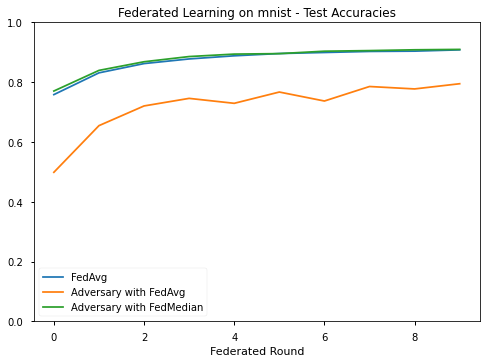

In [113]:
plt.style.use('seaborn-notebook')
sns.lineplot(list(range(len(testAccs))), [v[1] for v in testAccs])
sns.lineplot(list(range(len(testAccsAdvMean))), [v[1] for v in testAccsAdvMean])
sns.lineplot(list(range(len(testAccsAdvMedian))), [v[1] for v in testAccsAdvMedian])
plt.legend(['FedAvg', 'Adversary with FedAvg', 'Adversary with FedMedian'], loc=0)
plt.title('Federated Learning on mnist - Test Accuracies')
plt.xlabel('Federated Round')
plt.ylim(0, 1)
#plt.savefig('figs/allacc.jpg')
plt.show()

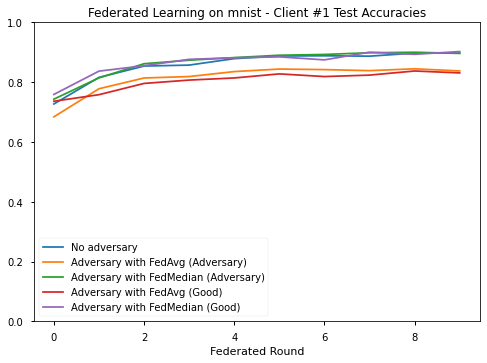

In [114]:
plt.style.use('seaborn-notebook')
sns.lineplot(list(range(len(testAccs))), [v[0][0][1] for v in clientResults])
sns.lineplot(list(range(len(testAccsAdvMean))), [v[0][0][1] for v in clientResultsAdvMean])
sns.lineplot(list(range(len(testAccsAdvMedian))), [v[0][0][1] for v in clientResultsAdvMedian])
sns.lineplot(list(range(len(testAccsAdvMean))), [v[1][0][1] for v in clientResultsAdvMean])
sns.lineplot(list(range(len(testAccsAdvMedian))), [v[1][0][1] for v in clientResultsAdvMedian])
plt.legend(['No adversary', 'Adversary with FedAvg (Adversary)', 'Adversary with FedMedian (Adversary)', 'Adversary with FedAvg (Good)', 'Adversary with FedMedian (Good)'], loc=0)
plt.title('Federated Learning on mnist - Client #1 Test Accuracies')
plt.xlabel('Federated Round')
plt.ylim(0, 1)
#plt.savefig('figs/allacc.jpg')
plt.show()

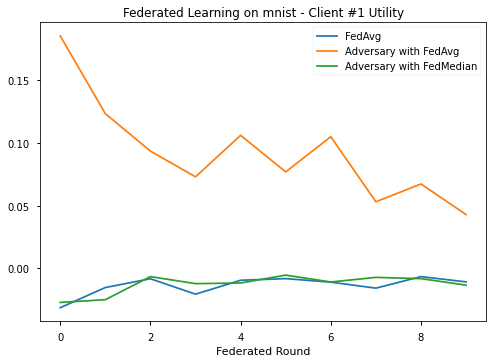

In [115]:
plt.style.use('seaborn-notebook')
sns.lineplot(list(range(len(testAccs))), [v[0][1] for v in clientResults])
sns.lineplot(list(range(len(testAccsAdvMean))), [v[0][1] for v in clientResultsAdvMean])
sns.lineplot(list(range(len(testAccsAdvMedian))), [v[0][1] for v in clientResultsAdvMedian])
plt.legend(['FedAvg', 'Adversary with FedAvg', 'Adversary with FedMedian'], loc=0)
plt.title('Federated Learning on mnist - Client #1 Utility')
plt.xlabel('Federated Round')
# plt.ylim(0, 1)
#plt.savefig('figs/allacc.jpg')
plt.show()